In [1]:
import glob
import os
import itertools
from pathlib import Path
from collections import defaultdict, OrderedDict

import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import mne_bids

from scipy.stats import ttest_1samp, median_abs_deviation
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

from results import get_noise_ceiling, get_results

In [2]:
REPORTS = Path("../../reports/plafrim_reports/")
DATA = Path("../../data")

bids_path = mne_bids.BIDSPath(
    subject="01", session="0", task="0", datatype="meg", root="../../data/raw"
)
raw = mne_bids.read_raw_bids(bids_path).load_data()

Extracting SQD Parameters from ../../data/raw/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from ../../data/raw/sub-01/ses-0/meg/sub-01_ses-0_task-0_events.tsv.
Reading channel info from ../../data/raw/sub-01/ses-0/meg/sub-01_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/tmp/ipykernel_74700/2856153779.py:7: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path).load_data()
/tmp/ipykernel_74700/2856153779.py:7: RuntimeWarning: participants.tsv file not found for ../../data/raw/sub-01/ses-0/meg/sub-01_ses-0_task-0_meg.con
  raw = mne_bids.read_raw_bids(bids_path).load_data()


In [3]:
rdf = get_results(REPORTS, "all", "all", "all")

In [17]:
rdf["feat"].unique()

array(['bert_1', 'bert_2', 'bert_20', 'bert_3', 'bert_4', 'bert_5',
       'bert_lag_5_1', 'bert_lag_5_2', 'bert_lag_5_3', 'bert_rh_20',
       'bert_rh_5', 'bert_rh_lag_5_1', 'bert_rh_lag_5_2',
       'bert_rh_lag_5_3'], dtype=object)

## Significant timing/sensors selection

In [4]:
ncdf = get_noise_ceiling(DATA, "all")
ncs = np.vstack(ncdf["nc"])

In [5]:
def fisher(x):
    return np.arctanh(x)

def inv_fisher(z):
    return np.tanh(z)

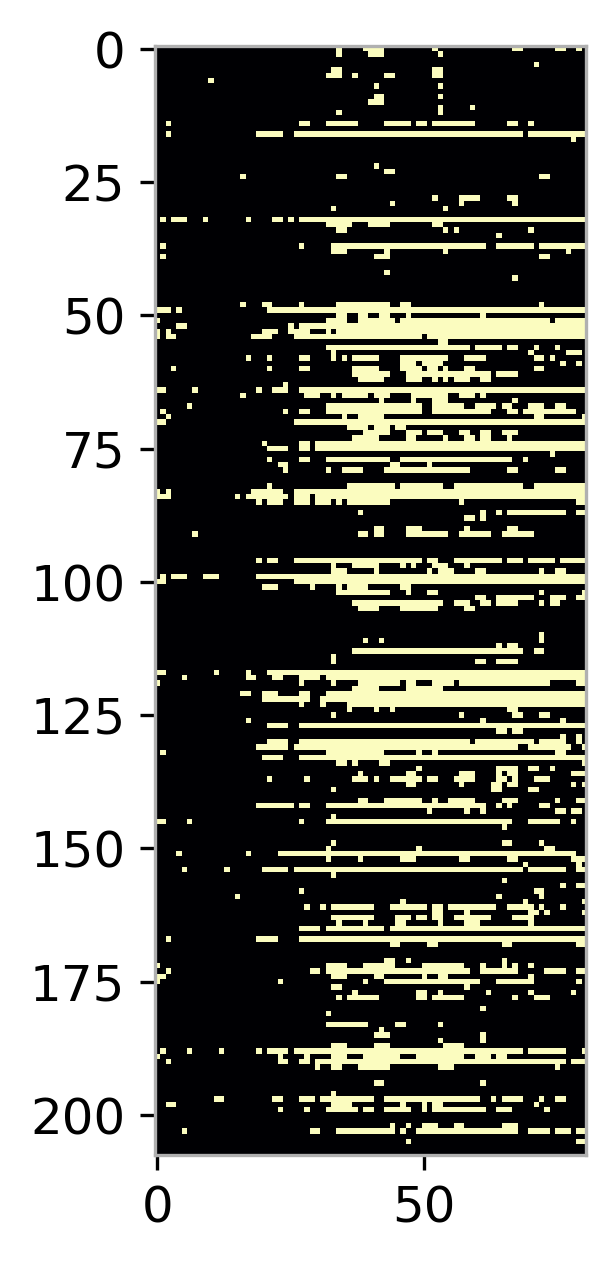

In [6]:
alpha = 0.01

s, p = ttest_1samp(fisher(ncs), 0.0, alternative="greater")
r, p_corrected = fdrcorrection(p, alpha=alpha)

plt.imshow((p_corrected < alpha).reshape(208, 81))
plt.show()

non_rois = np.where(p_corrected >= alpha)
rois = np.where(p_corrected < alpha)

## Median correlation, subject-wise (for significant timings/sensors)

In [32]:
def median_ncorr(df, ncs, feat, layer, rois):
    corr = df.set_index(["feat", "layer"]).sort_index().loc[feat, layer]["corr"].values
    #nc = ncs.set_index(["feat", "layer"]).sort_index().loc[feat, layer]["nc"].values

    corr = np.concatenate([arr[:, np.newaxis] for arr in corr], axis=1)[:, :, 0]
    #nc = np.concatenate([arr[:, np.newaxis] for arr in nc], axis=1)
    
    ncorr = corr / ncs.T
    #ncorr = np.clip(ncorr, -1.0, 1.0)
    ncorr[non_rois] = 0.0

    return np.median(ncorr[rois], axis=0) # median of sensors/timepoints

### BERT1-20

In [33]:
medians = list()
med_dict = list()
feats = ["bert_1", "bert_2", "bert_3", "bert_4", "bert_5", "bert_20"]
layers = rdf["layer"].unique()

for feat in feats:
    med = []
    for layer in layers:
        m = median_ncorr(rdf, ncs, feat, layer, rois)
        med.append(m)
        
        for mm in m:
            med_d = dict()

            med_d["median"] = mm
            med_d["layer"] = layer
            med_d["feat"] = feat
            med_dict.append(med_d)
        

    medians.append(med)
    
medians = np.array(medians)
mdf = pd.DataFrame(med_dict)
mdf

,median,layer,feat
0,-0.253643,0,bert_1
1,0.193299,0,bert_1
2,0.140636,0,bert_1
3,0.153107,0,bert_1
4,-0.145489,0,bert_1
...,...,...,...
1939,0.378967,11,bert_20
1940,-0.010136,11,bert_20
1941,0.493296,11,bert_20
1942,0.772973,11,bert_20


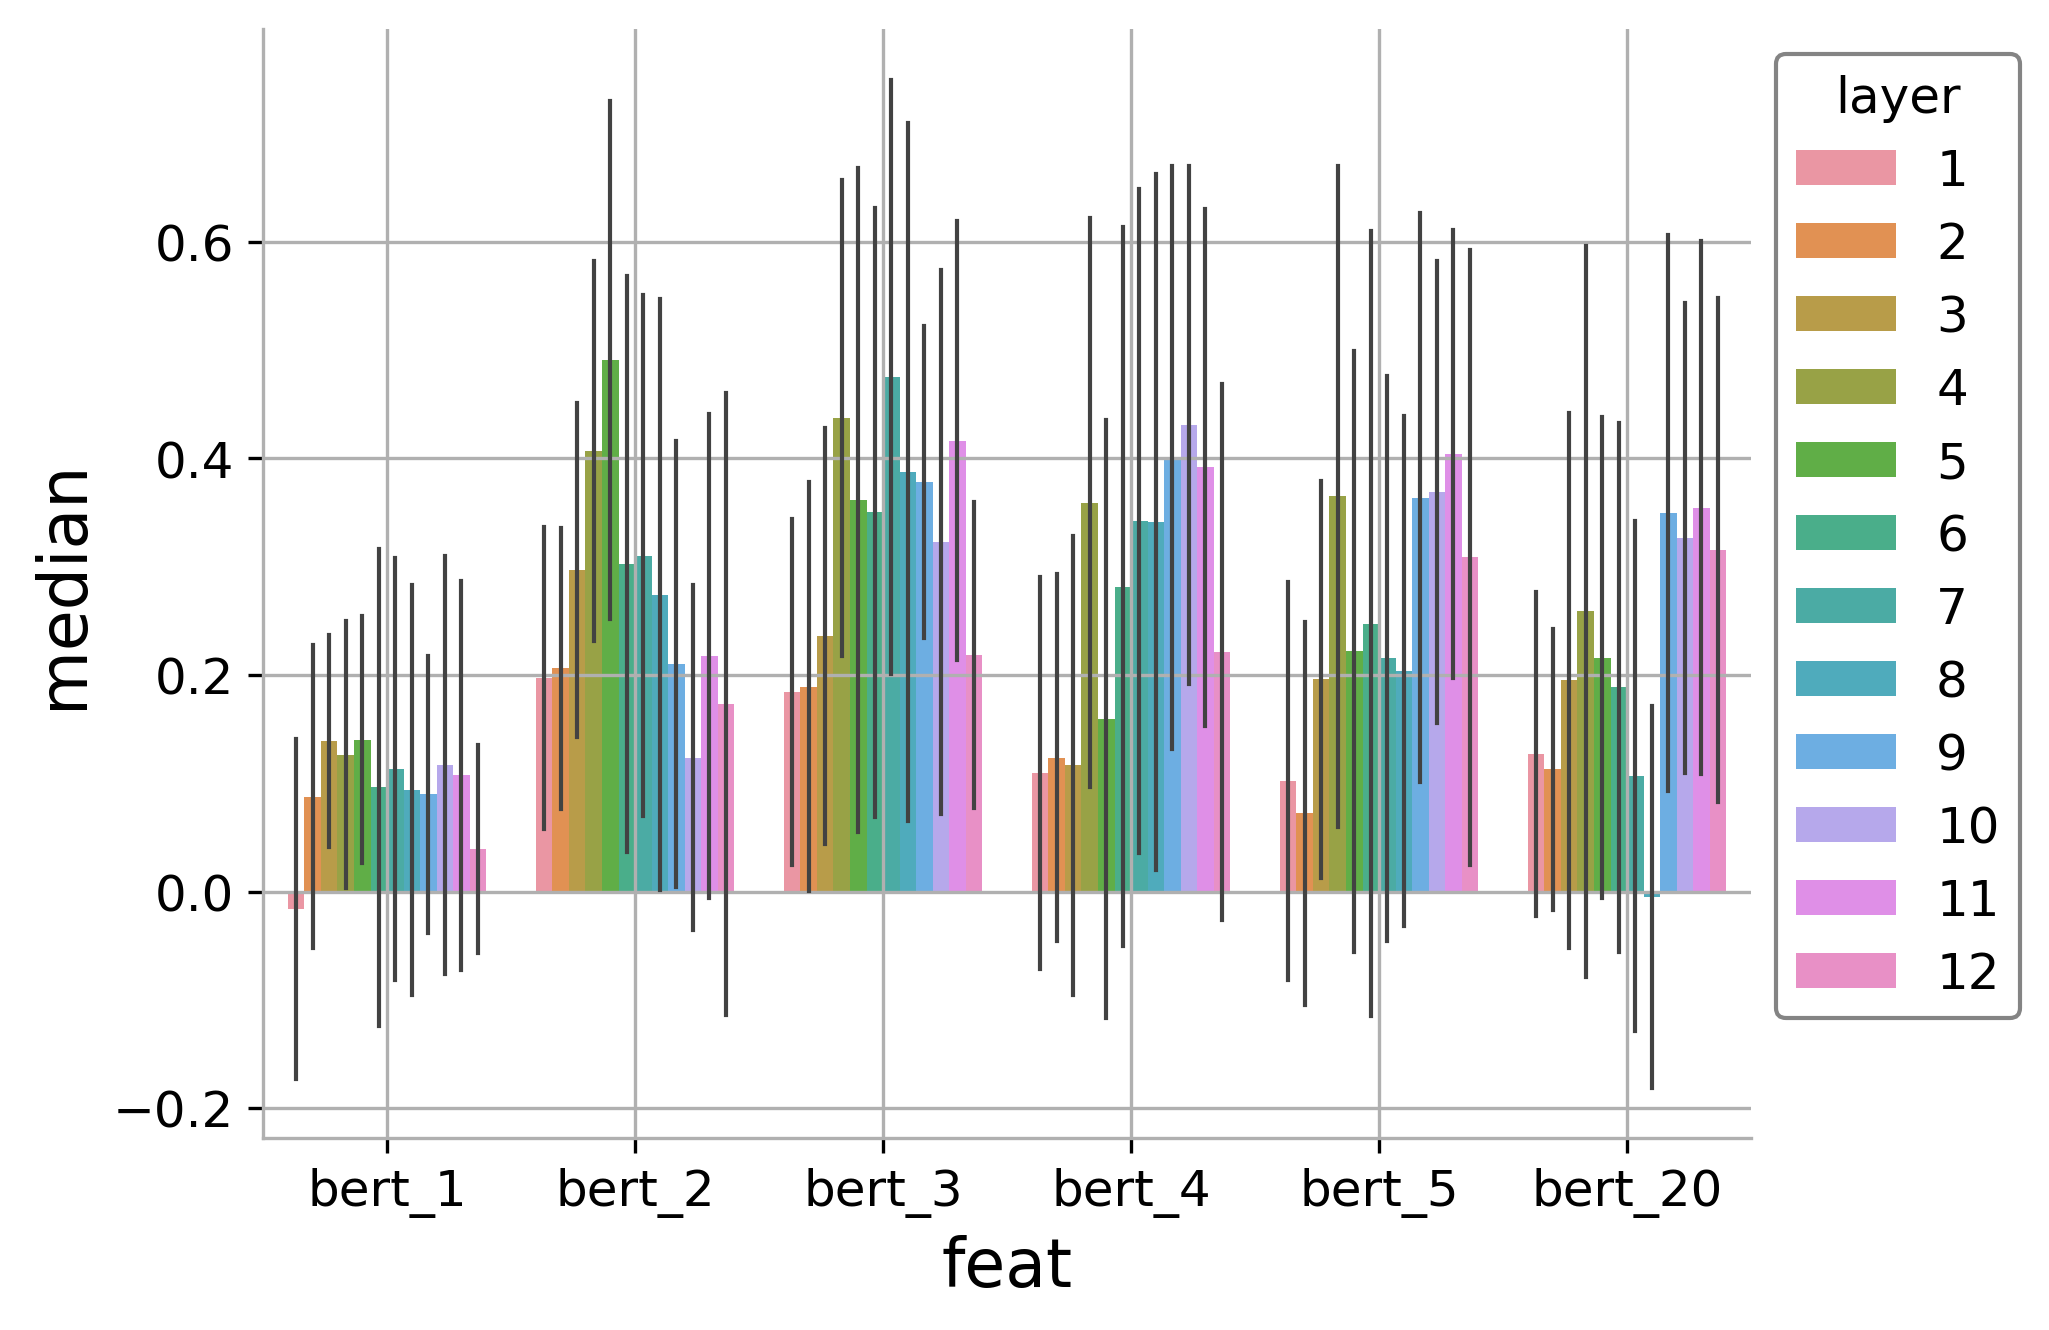

In [34]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x="feat", y="median", hue=mdf["layer"]+1, dodge=True, data=mdf, estimator=med, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig("figures/sig_median_corr_bert1-20_featwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert1-20_featwise.pdf", bbox_inches="tight")
plt.show()

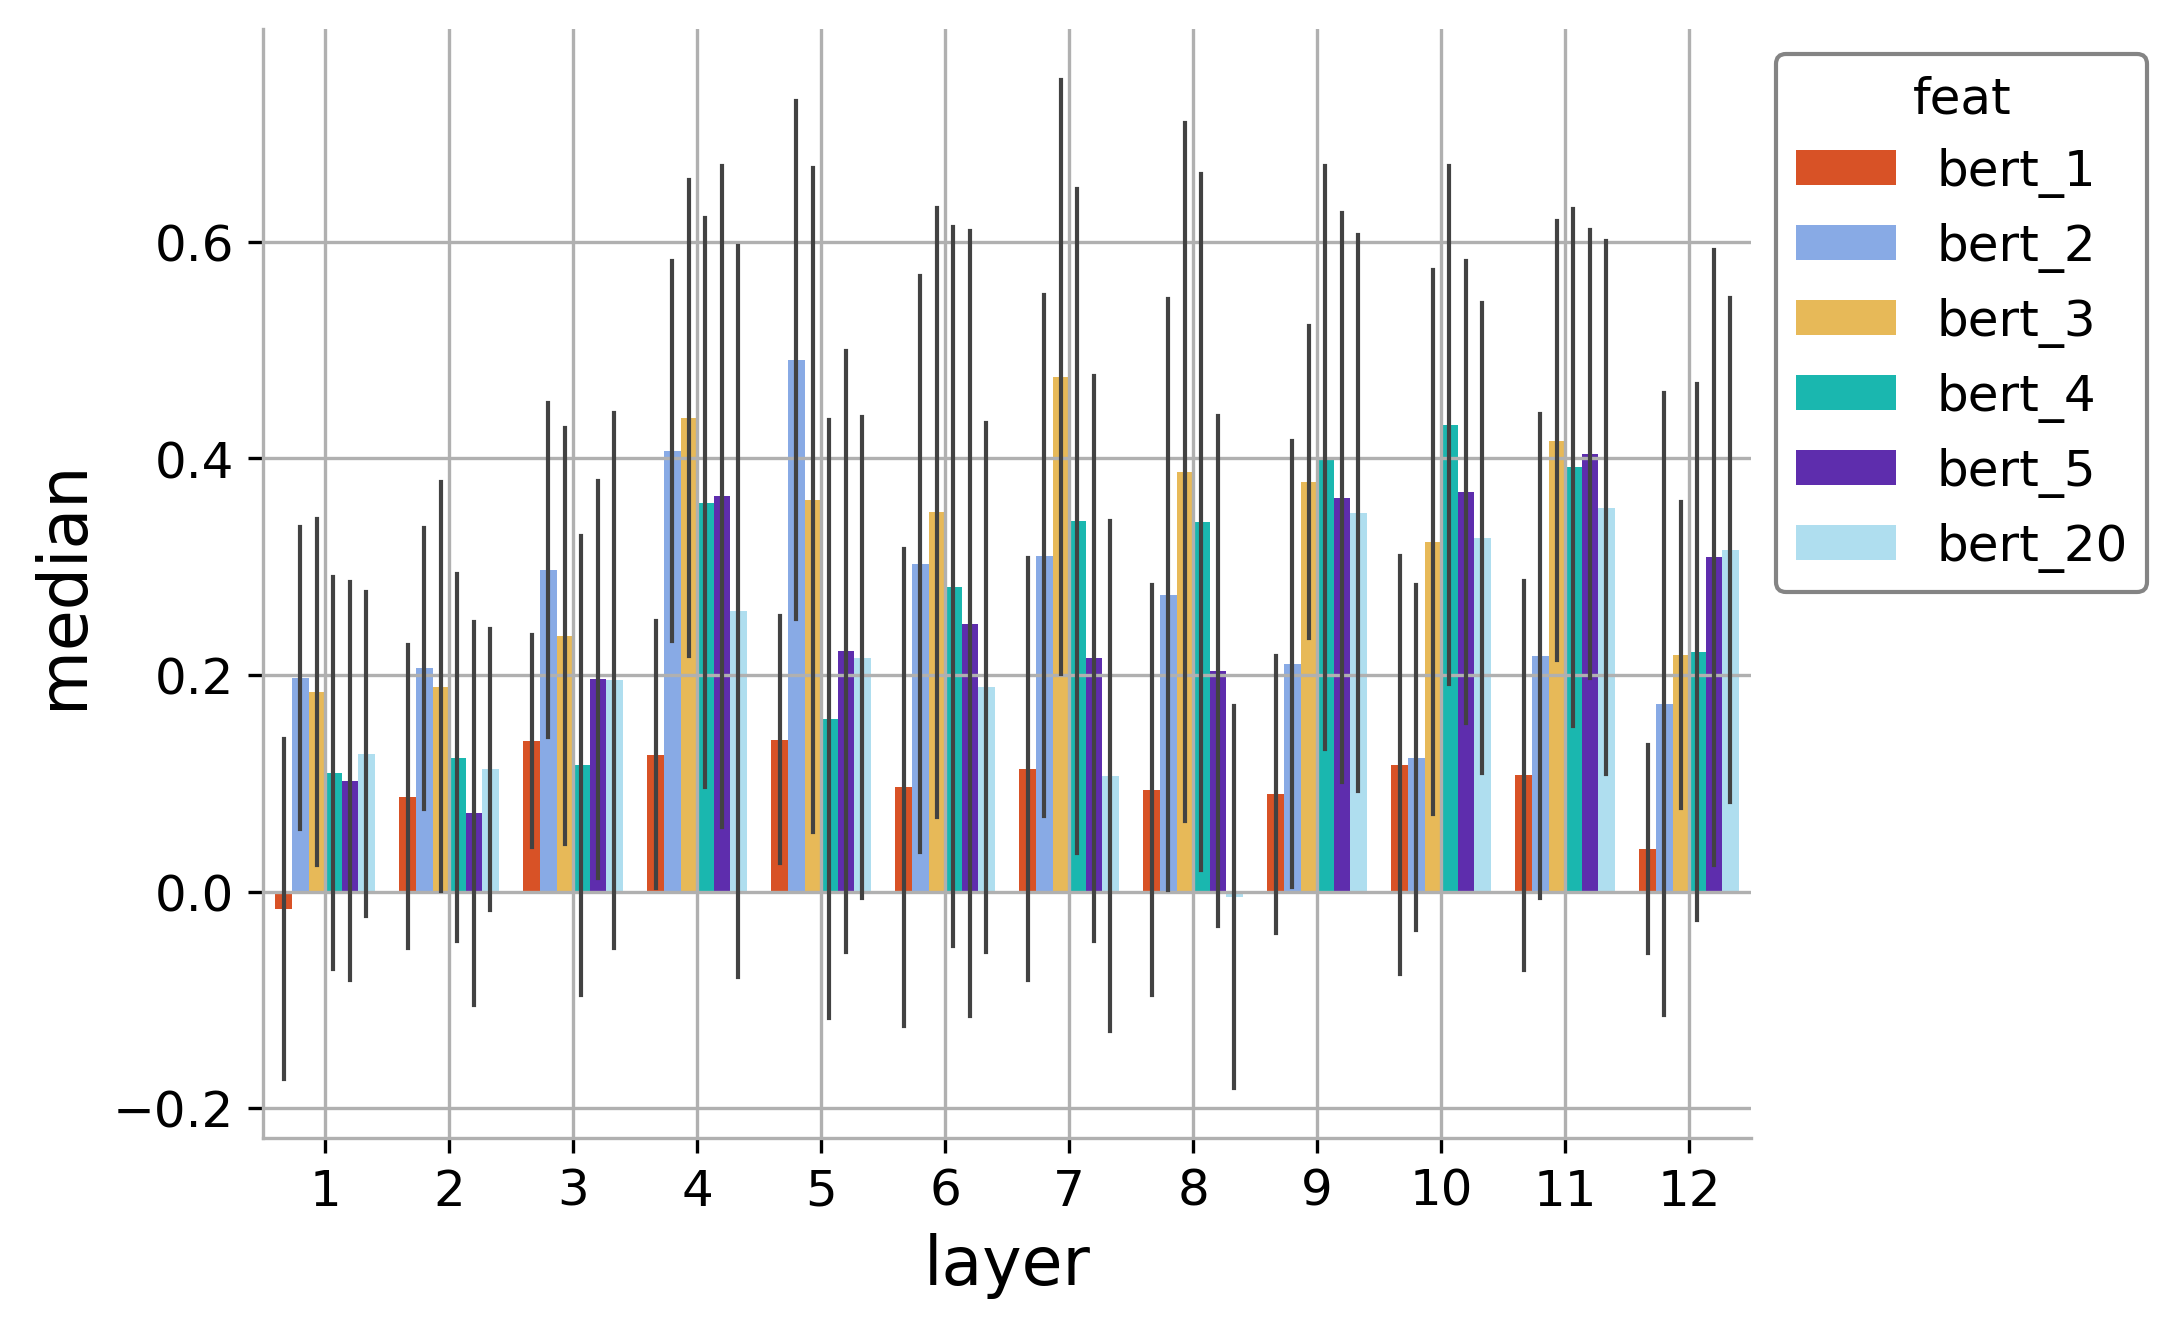

In [35]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x=mdf["layer"]+1, y="median", hue="feat", dodge=True, data=mdf, estimator=np.median, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig("figures/sig_median_corr_bert1-20_layerwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert1-20_layerwise.pdf", bbox_inches="tight")
plt.show()

## BERT right vs BERT left

In [36]:
medians = list()
med_dict = list()
feats = ["bert_5", "bert_20", "bert_rh_5", "bert_rh_20"]
layers = rdf["layer"].unique()

for feat in feats:
    med = []
    for layer in layers:
        m = median_ncorr(rdf, ncs, feat, layer, rois)
        med.append(m)
        
        for mm in m:
            med_d = dict()

            med_d["median"] = mm
            med_d["layer"] = layer
            med_d["feat"] = feat
            med_dict.append(med_d)
        

    medians.append(med)
    
medians = np.array(medians)
mdf = pd.DataFrame(med_dict)
mdf

,median,layer,feat
0,-0.263119,0,bert_5
1,-0.048252,0,bert_5
2,0.362826,0,bert_5
3,0.377175,0,bert_5
4,-0.157969,0,bert_5
...,...,...,...
1291,-0.341729,11,bert_rh_20
1292,-0.329135,11,bert_rh_20
1293,0.197774,11,bert_rh_20
1294,0.010460,11,bert_rh_20


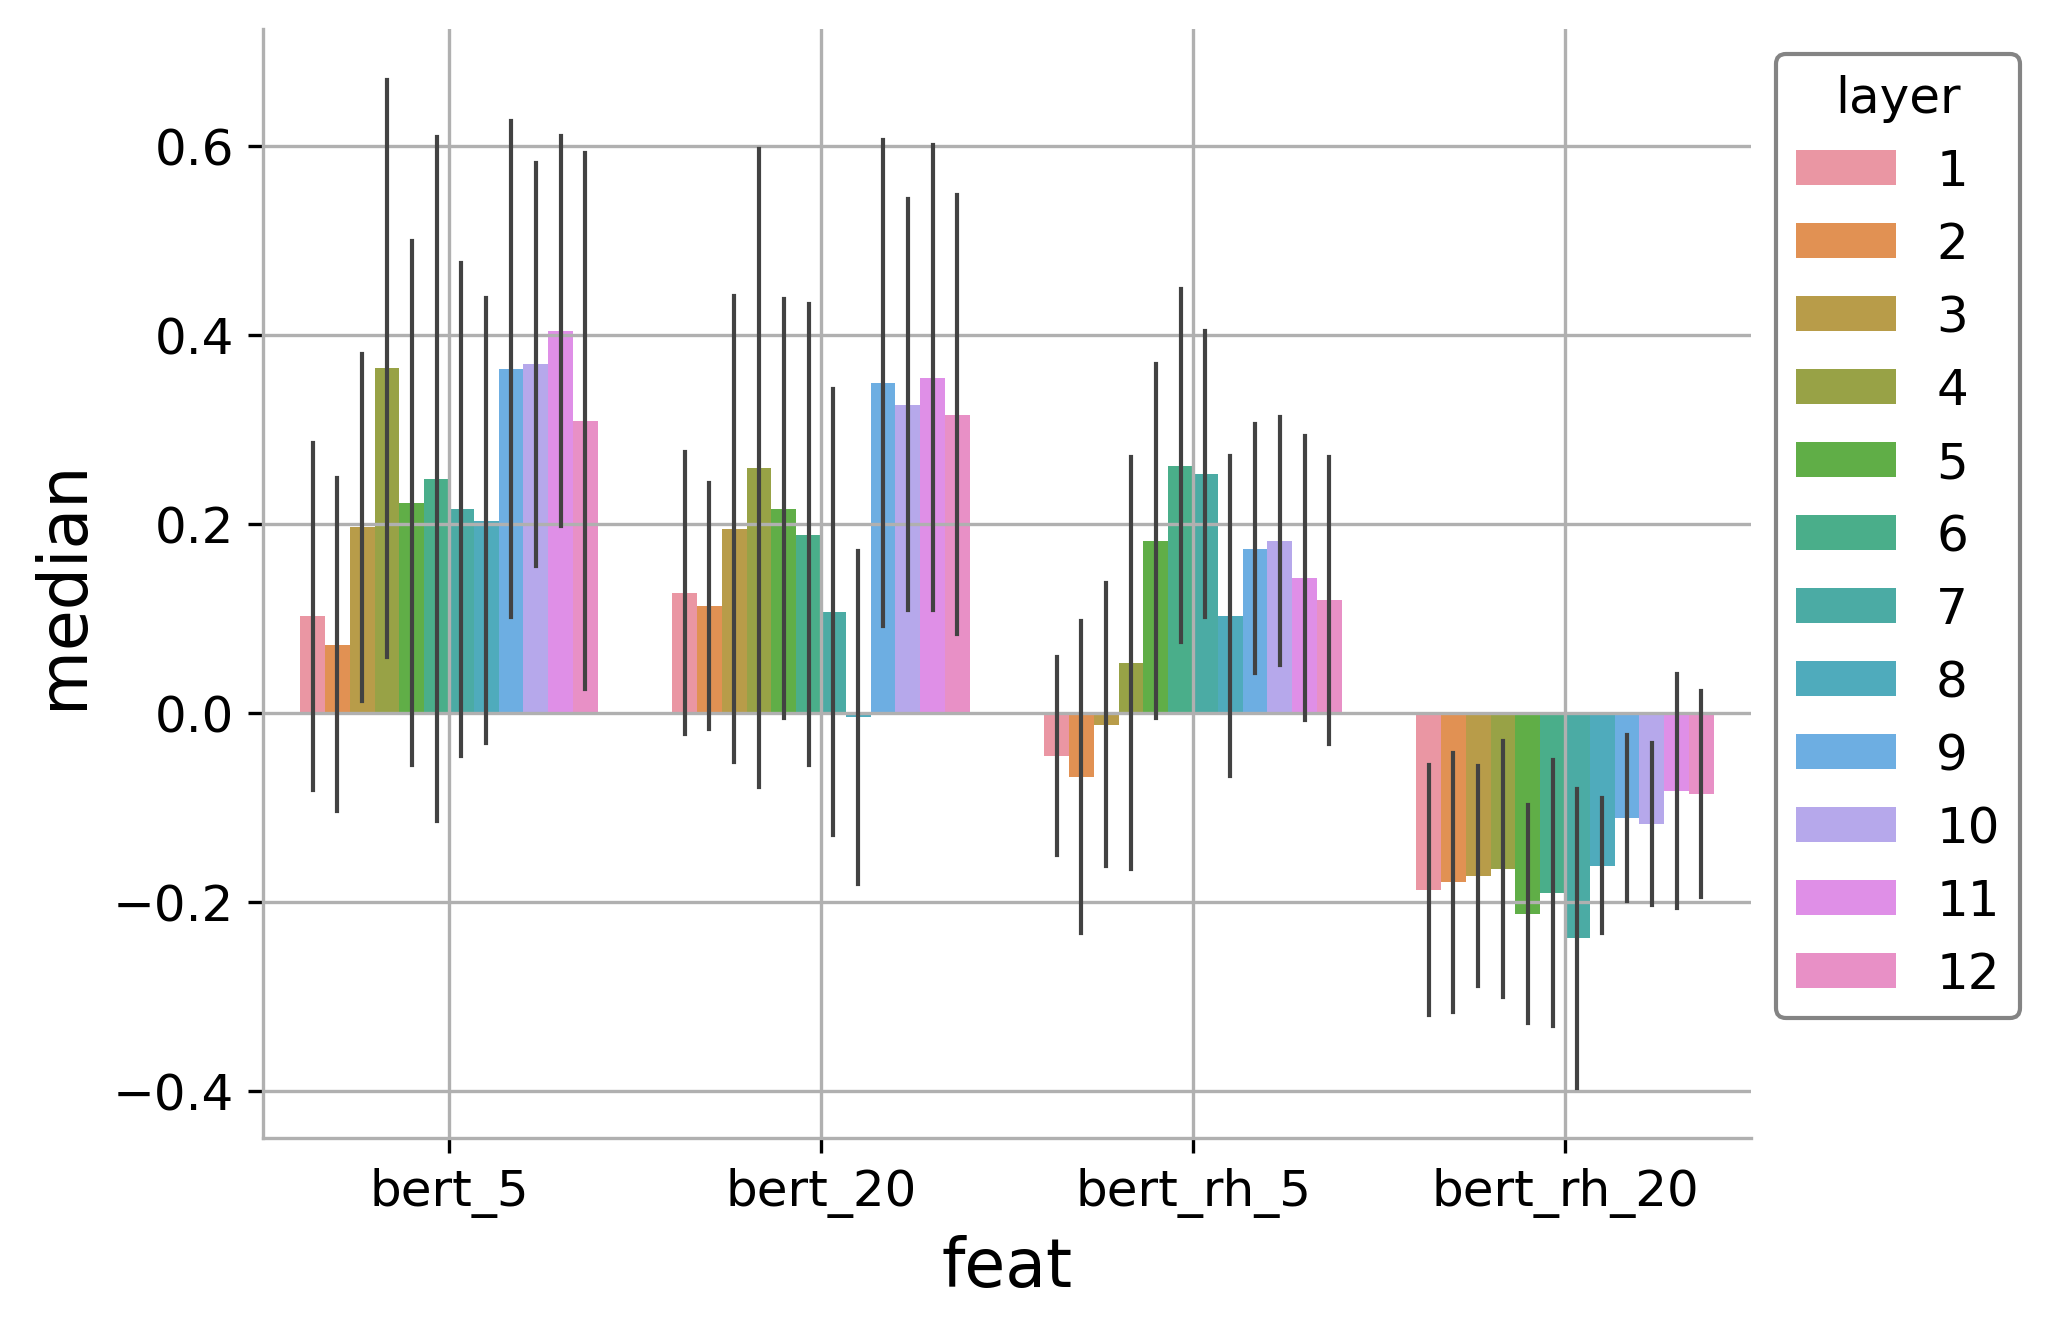

In [37]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x="feat", y="median", hue=mdf["layer"]+1, dodge=True, data=mdf, estimator=med, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig("figures/sig_median_corr_bert-right_left_featwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert1-right_left_featwise.pdf", bbox_inches="tight")
plt.show()

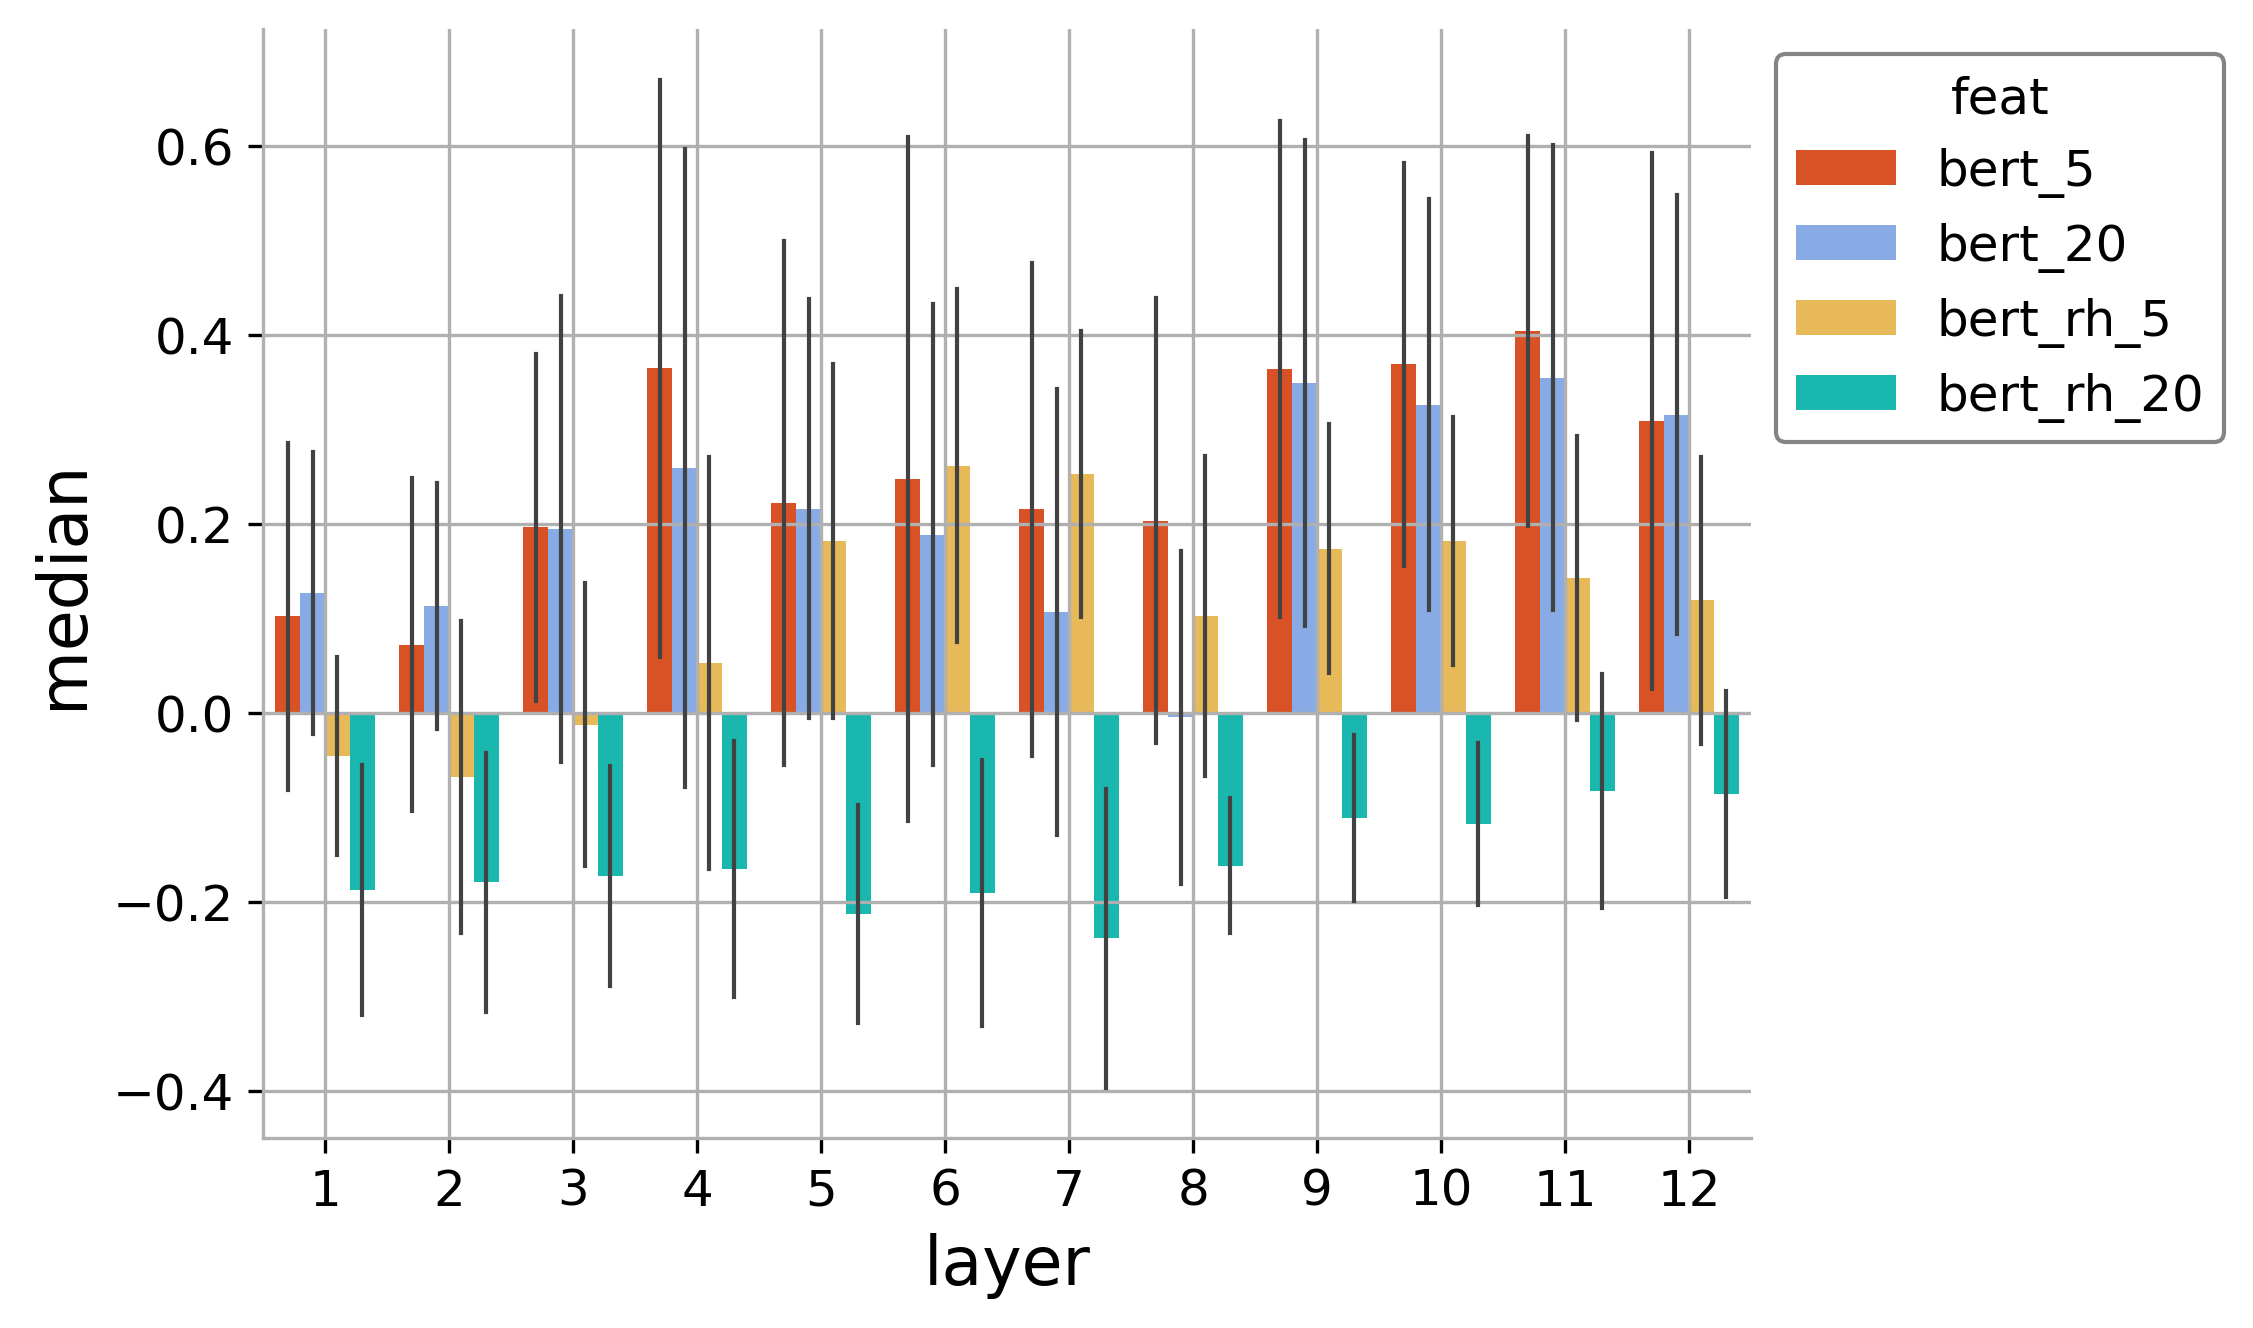

In [38]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x=mdf["layer"]+1, y="median", hue="feat", dodge=True, data=mdf, estimator=np.median, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig("figures/sig_median_corr_bert-right_left_layerwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert-right_left_layerwise.pdf", bbox_inches="tight")
plt.show()

## Lag

In [46]:
medians = list()
med_dict = list()
feats = ['bert_lag_5_3',  'bert_lag_5_2', 'bert_lag_5_1', 'bert_5', 'bert_rh_lag_5_1', 'bert_rh_lag_5_2',
         'bert_rh_lag_5_3']
layers = rdf["layer"].unique()

for feat in feats:
    med = []
    for layer in layers:
        m = median_ncorr(rdf, ncs, feat, layer, rois)
        med.append(m)
        
        for mm in m:
            med_d = dict()

            med_d["median"] = mm
            med_d["layer"] = layer
            med_d["feat"] = feat
            med_dict.append(med_d)
        

    medians.append(med)
    
medians = np.array(medians)
mdf = pd.DataFrame(med_dict)
mdf

,median,layer,feat
0,-0.464818,0,bert_lag_5_3
1,-0.191551,0,bert_lag_5_3
2,0.007125,0,bert_lag_5_3
3,-0.078149,0,bert_lag_5_3
4,-0.018452,0,bert_lag_5_3
...,...,...,...
2263,-0.067695,11,bert_rh_lag_5_3
2264,-0.000352,11,bert_rh_lag_5_3
2265,-0.041009,11,bert_rh_lag_5_3
2266,-0.275904,11,bert_rh_lag_5_3


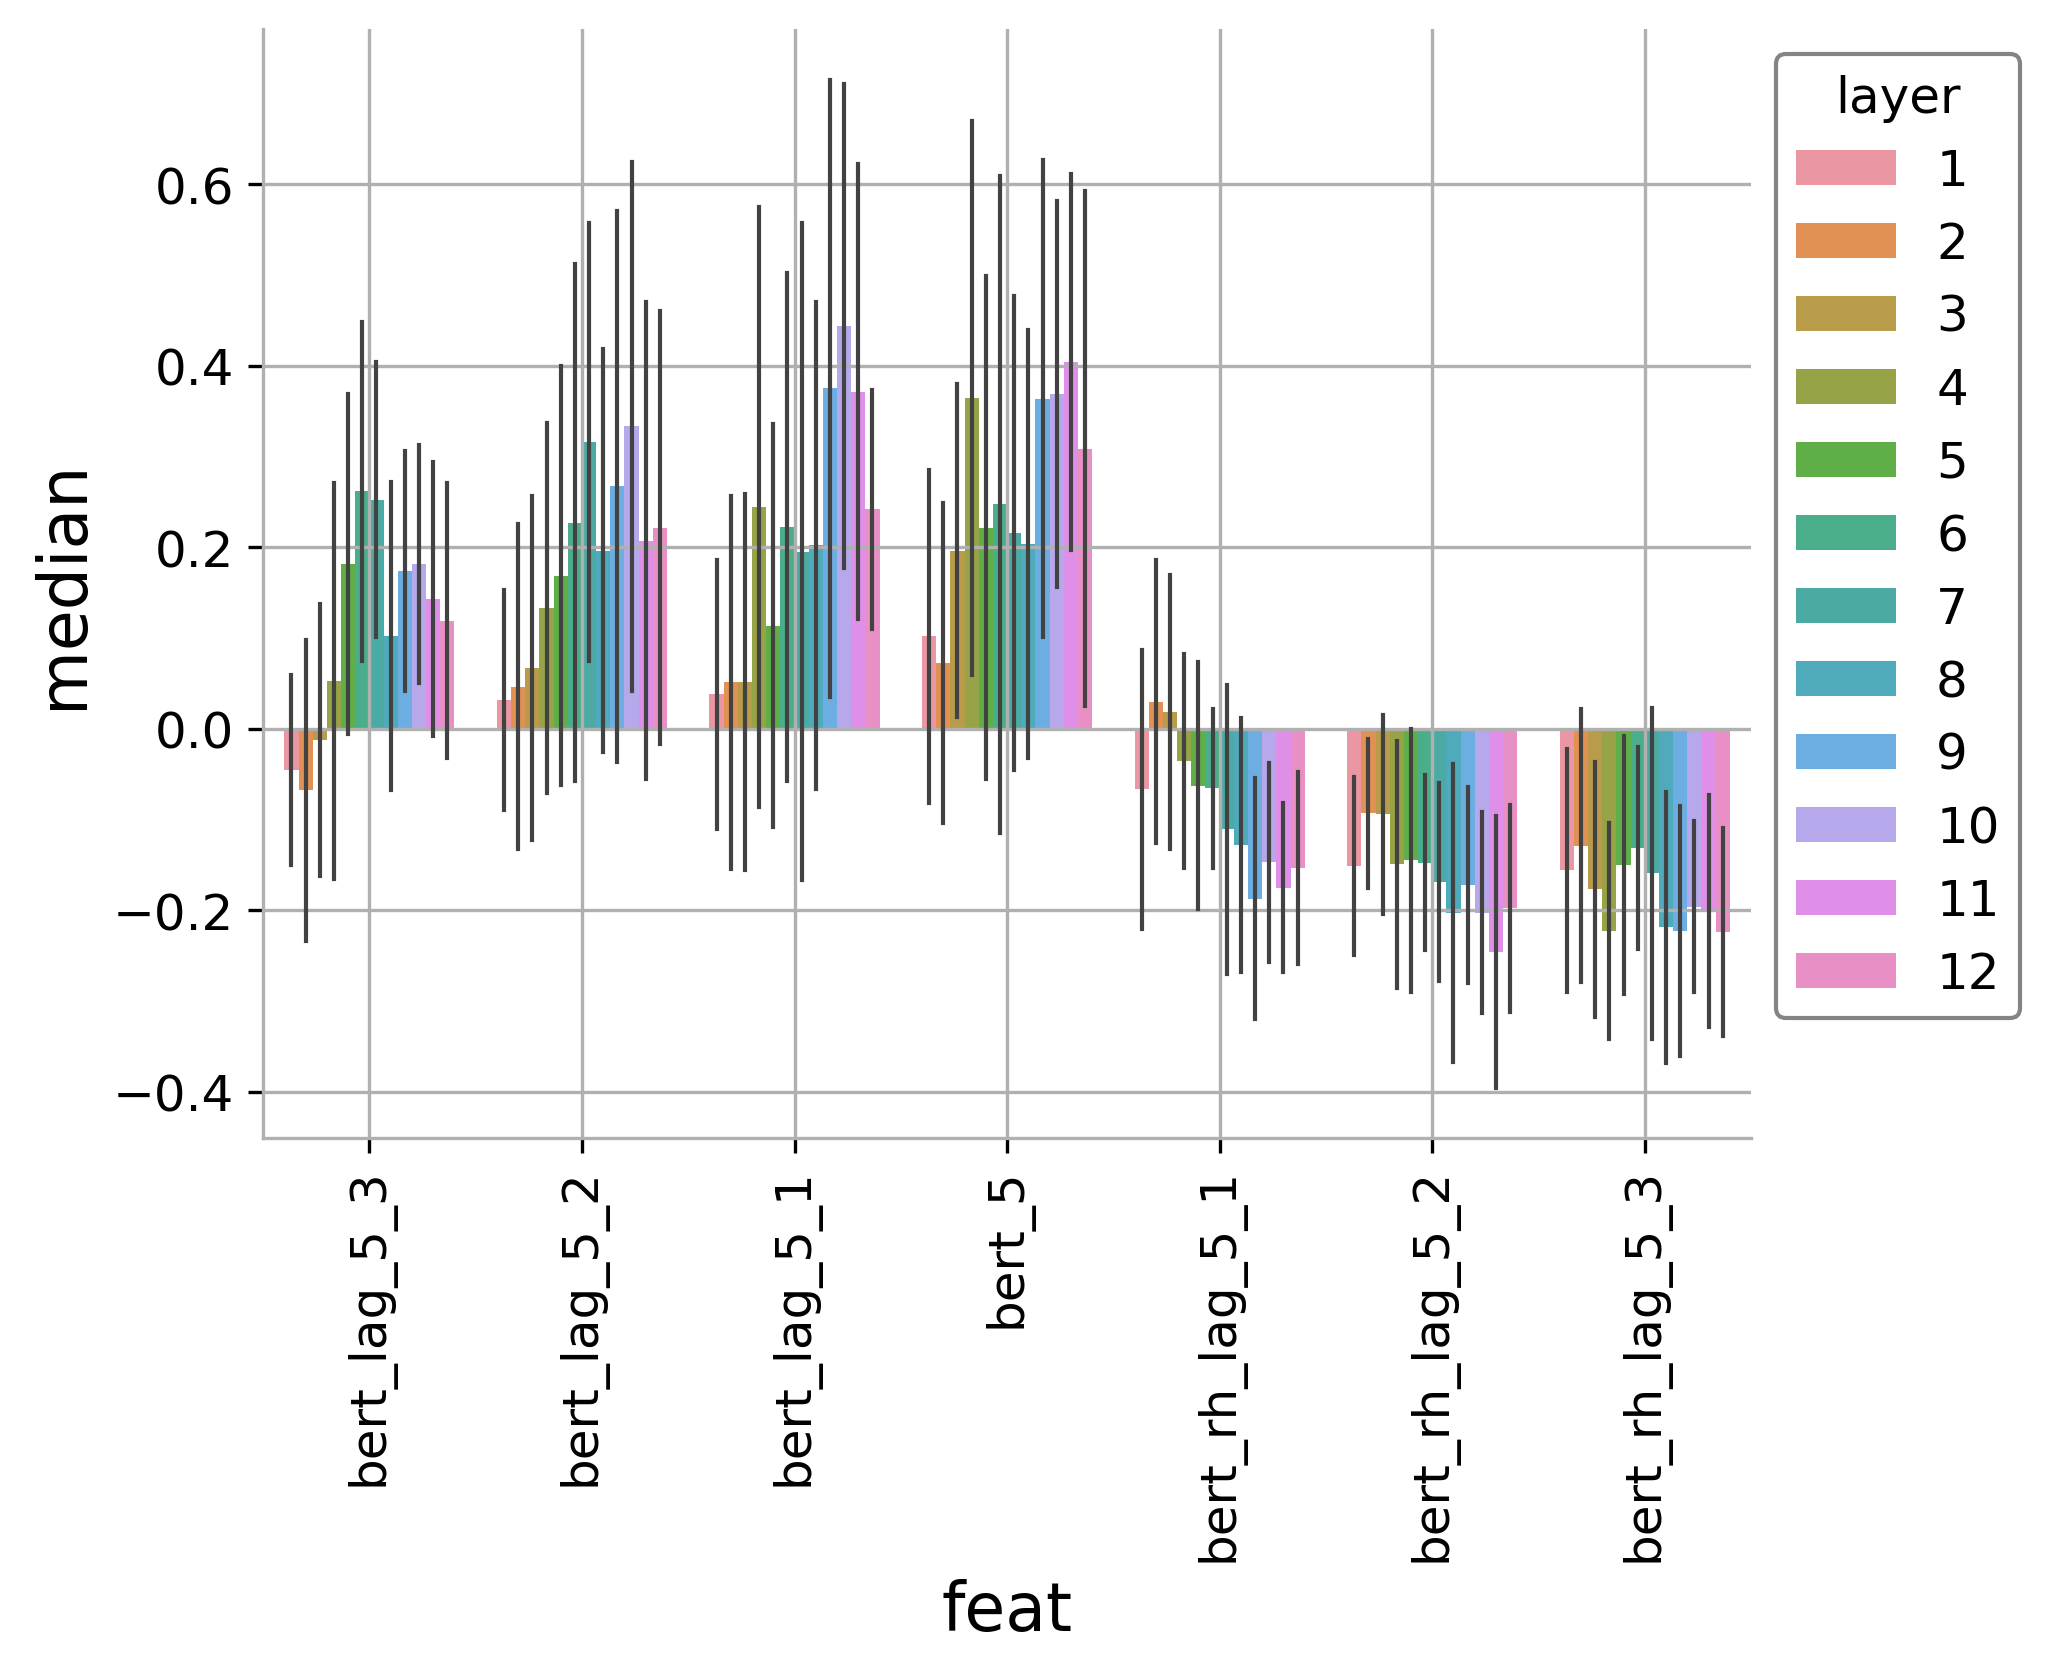

In [47]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x="feat", y="median", hue=mdf["layer"]+1, dodge=True, data=mdf, estimator=med, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.xticks(rotation=90)
plt.savefig("figures/sig_median_corr_bert-lag_featwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert-lag_featwise.pdf", bbox_inches="tight")
plt.show()

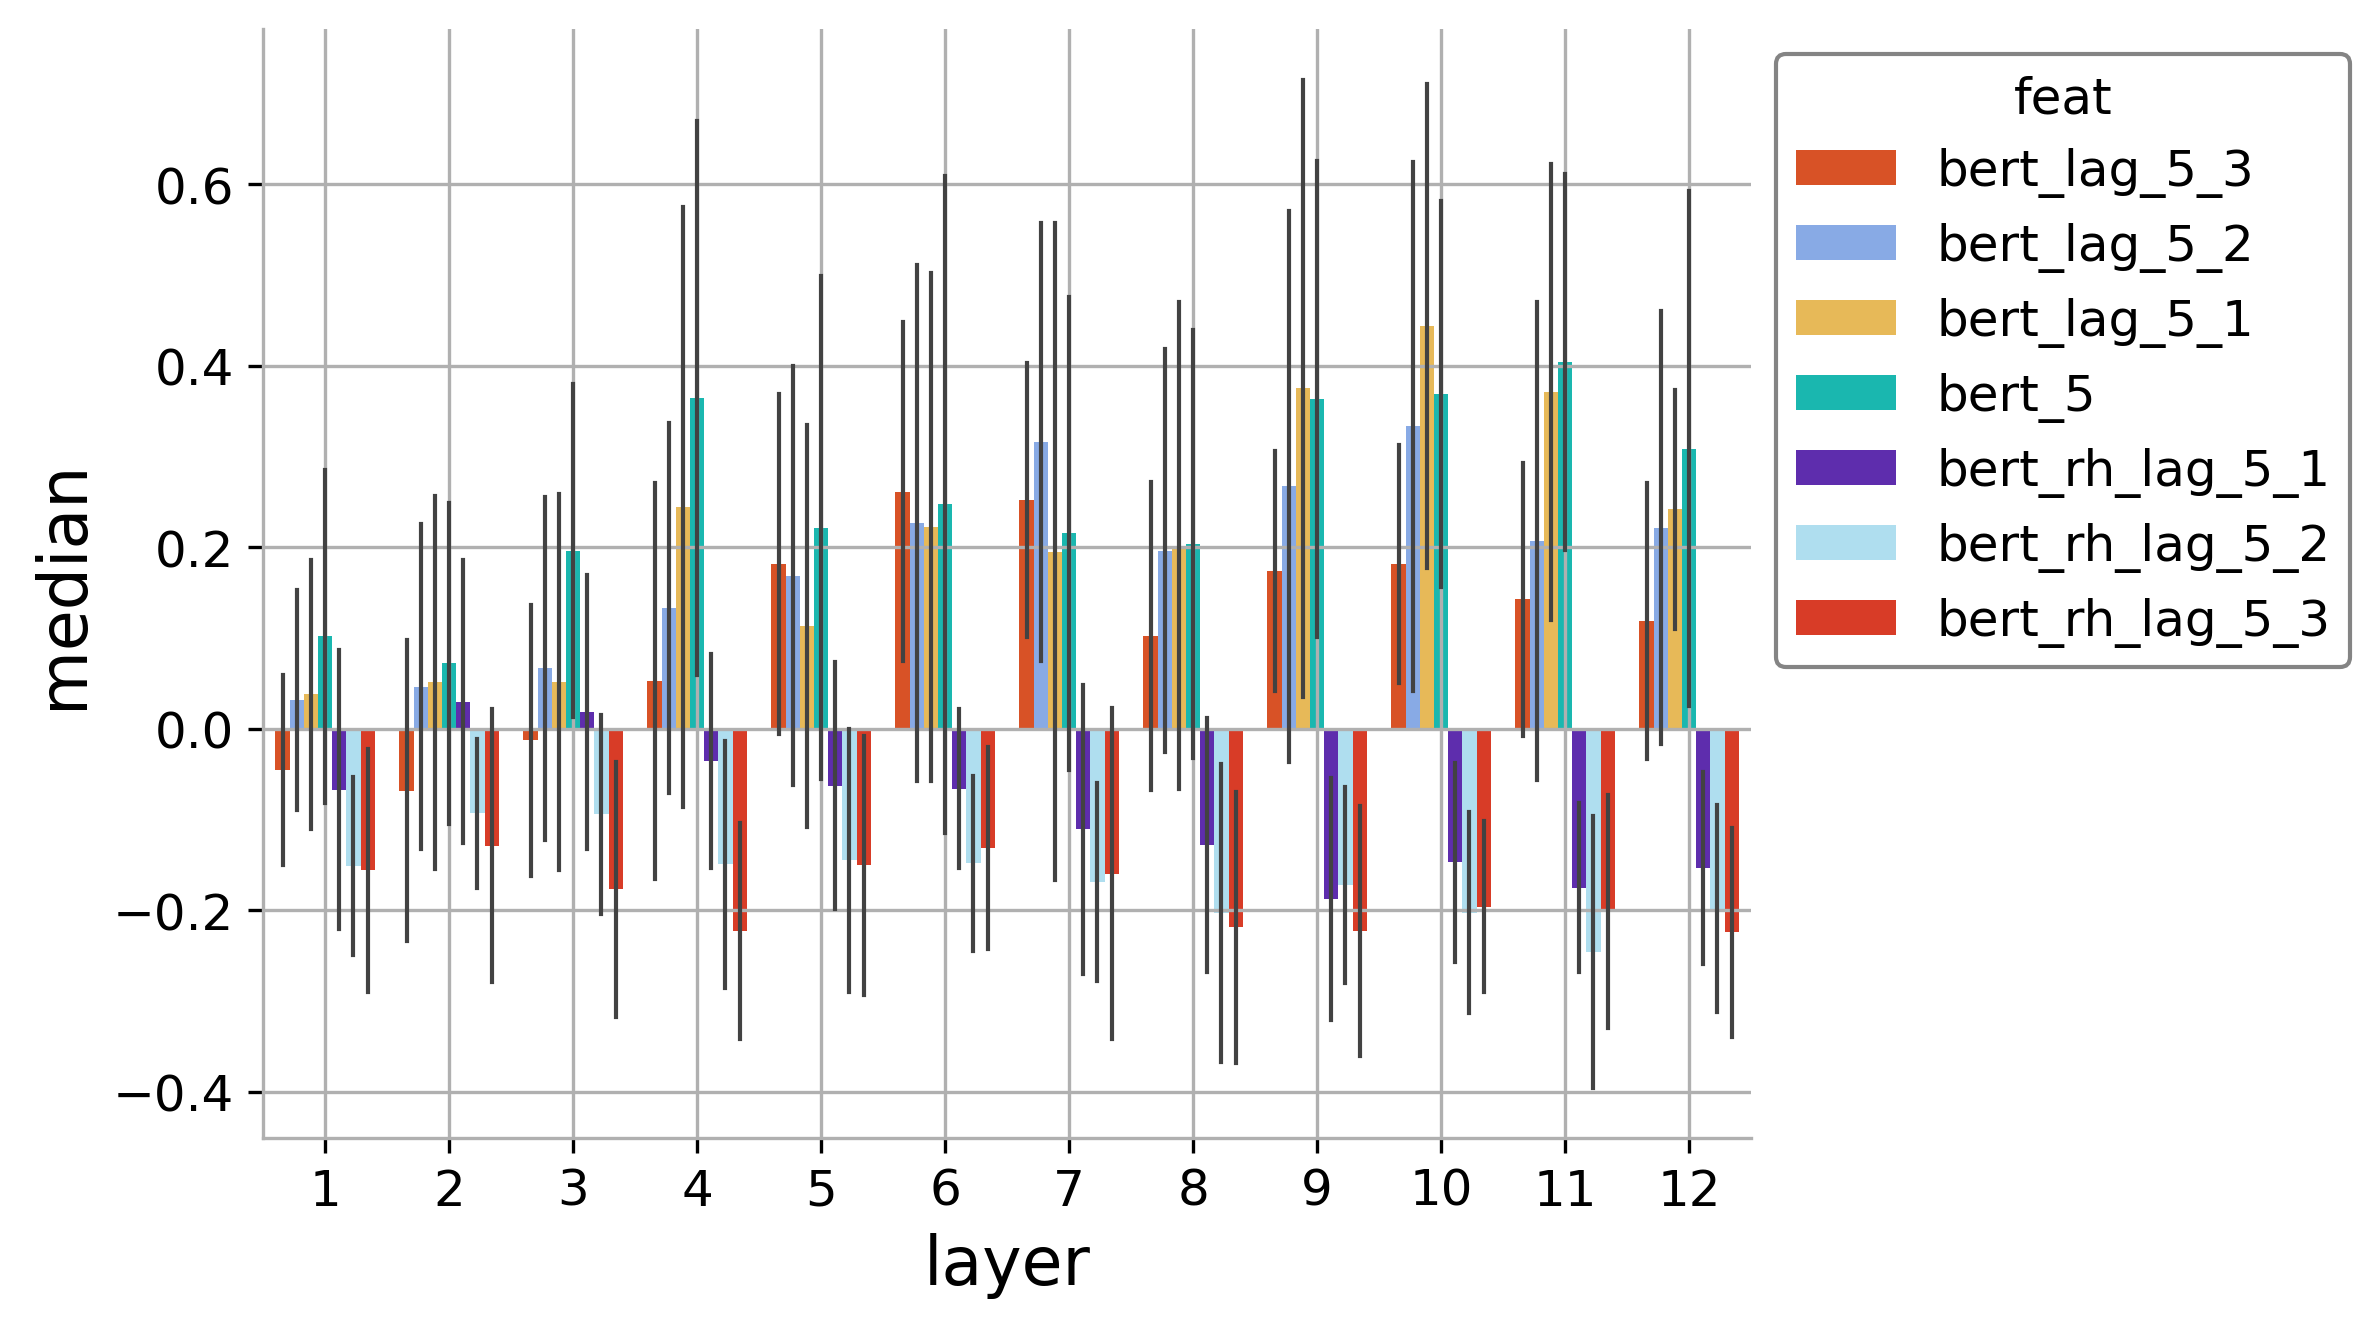

In [48]:
mas = scipy.stats.median_abs_deviation
med = np.median
error = lambda x: (-mas(x) + med(x), mas(x) + med(x))
ax = sns.barplot(x=mdf["layer"]+1, y="median", hue="feat", dodge=True, data=mdf, estimator=np.median, errorbar=error, errwidth=1)
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.savefig("figures/sig_median_corr_bert-lag_layerwise.png", bbox_inches="tight")
plt.savefig("figures/sig_median_corr_bert-lag_layerwise.pdf", bbox_inches="tight")
plt.show()